# Time Series Modeling and Forecasting with ARIMA

In [99]:
# machinelearningplus.com
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from dateutil.parser import parse
import pandas as pd
import pandas_datareader.data as web
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
import datetime as dt
import ta
from scipy import signal

In [63]:
# import stock data from yahoo
start = dt.datetime(2000,1,1)
end = dt.datetime(2020,2,12)

#load data from yahoo
df = web.DataReader('MSFT', 'yahoo', start, end)

In [64]:
# Seasonal Plot of Stock Price
df.reset_index(inplace=True)
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()

In [65]:
np.random.seed(100)
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

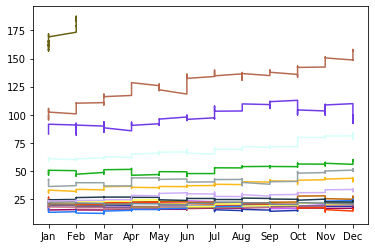

In [66]:
plt.figure()
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'Adj Close', data=df.loc[df.year==y, :], color=colors[i], label=y)
        #plt.text(df.loc[df.year==y, :].shape[0]-100, df.loc[df.year==y, 'Adj Close'][-1:].values[0], y, fontsize=12, color=colors[i])
        

plt.show()
    

In [67]:
# trend and seasonality
#multiplicative decomposition

# this doesn't seem to work for stock data bc there is no inferred frequency
# result_mul = seasonal_decompose(df['Adj Close'].loc[df.year==2019], model='multiplicative',
#                                extrapolate_trend='freq')

# result_mul = seasonal_decompose(df['Adj Close'].loc[df.year==2019], model='additive',
#                                extrapolate_trend='freq')

# perhaps another way this might be done is by trying to find the frequency
# of a technical indicator like the RSI
# or maybe look into another stock that is in a more cyclical industry

In [68]:
# trying to find trend and seasonality of RSI

# RSI
indicator_rsi = ta.momentum.RSIIndicator(close=df["Adj Close"], fillna=True)
df['rsi'] = indicator_rsi.rsi()

# MACD
macd = ta.trend.MACD(close=df['Adj Close'], fillna=True)
df['MACD_diff'] = macd.macd_diff()

# 200 day SMA
indicator_sma = ta.trend.SMAIndicator(close=df["Adj Close"], n=200, fillna=True)
df['sma_200'] = indicator_sma.sma_indicator()
df['sma_200_sig'] = (df['Adj Close'] > df['sma_200']).astype(int)

# 100 day SMA
indicator_sma = ta.trend.SMAIndicator(close=df["Adj Close"], n=100, fillna=True)
df['sma_100'] = indicator_sma.sma_indicator()
df['sma_100_sig'] = (df['Adj Close'] > df['sma_100']).astype(int)

# 50 day SMA
indicator_sma = ta.trend.SMAIndicator(close=df["Adj Close"], n=50, fillna=True)
df['sma_50'] = indicator_sma.sma_indicator()
df['sma_50_sig'] = (df['Adj Close'] > df['sma_50']).astype(int)

# 21 day EMA
indicator_ema = ta.trend.EMAIndicator(close=df["Adj Close"], n=21, fillna=True)
df['ema_21'] = indicator_ema.ema_indicator()
df['ema_21_sig'] = (df['Adj Close'] > df['ema_21']).astype(int)

# 14 day EMA
indicator_ema = ta.trend.EMAIndicator(close=df["Adj Close"], n=14, fillna=True)
df['ema_14'] = indicator_ema.ema_indicator()
df['ema_14_sig'] = (df['Adj Close'] > df['ema_14']).astype(int)

# 7 day EMA
indicator_ema = ta.trend.EMAIndicator(close=df["Adj Close"], n=7, fillna=True)
df['ema_7'] = indicator_ema.ema_indicator()
df['ema_7_sig'] = (df['Adj Close'] > df['ema_7']).astype(int)

In [19]:
# this doesn't seem to work either - atleast for MSFT

# result_mul = seasonal_decompose(df['rsi'], model='additive',
#                                extrapolate_trend='freq')

# I tried to do the same for a few other stocks and none of them worked
# I tried stocks regarded as cylical, I tried 1, 10, and 20 year periods.
# I tried both RSI and adjusted close

# start = dt.datetime(2019,1,1)
# end = dt.datetime(2020,1,1)
# df = web.DataReader('MU', 'yahoo', start, end)
# df.reset_index(inplace=True)
# df['year'] = [d.year for d in df.Date]
# df['month'] = [d.strftime('%b') for d in df.Date]
# years = df['year'].unique()
# indicator_rsi = ta.momentum.RSIIndicator(close=df["Adj Close"], fillna=True)
# df['rsi'] = indicator_rsi.rsi()
# result_mul = seasonal_decompose(df['rsi'], model='additive',extrapolate_trend=1)

# Stationary and Non-stationary time series
A stationary series is one in which a shift in time will not change the distribution. The mean, variance and autocorrelation are constant over time. Autocorrelation is a measure of how the series is correlated with its previous values, or in other words, the correlation of a signal with a delayed copy of itself.

According to author, it is possible to make nearly any time series stationary by applying a suitable transformation. You can make a time series staionary by:

1. Differencing the the series once or more
2. Take the log of the series
3. Take the nth root of the series
4. Combination of above

Differencing the series is subtracting the next value by the current value.
Making a series stationary is helpful becuase autoregressive forecasting is essentially linear regression that utilizes the lag of the series itself as predictors. Linear regression works best if the inputs are not correlated - and stationarizing the series solves this problem.

One way to test for stationarity is by Unit Root Tests

# ADH Test: 
Null hypothesis is the time series possesses a unit root and is non-stationary. If the P-value is less than the significance level (0.05), you reject the null Hypothesis.

# KPSS Test
Used to test trend stationarity. The null hypothesis and p-value interpretation are the opposite of the ADH test.

In [20]:
def difference(series):
    series = list(series)
    for i in range(len(series)-1):
        series[i]=series[i+1]-series[i]
    series.pop()
    return series

s = np.array([1, 5, 2, 12, 20])
print(difference(s))

[4, -3, 10, 8]


In [21]:
# ADF Test
result = adfuller(df['Adj Close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'{key}, {value}')
    
pval = result[1]
if pval < 0.05:
    print("Stationary")
else: print('Non-Stationary')
    
# ADF Test
result = adfuller(df['rsi'].values, autolag='AIC')
print('\nRSI')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'{key}, {value}')
    
pval = result[1]
if pval < 0.05:
    print("Stationary")
else: print('Non-Stationary')

ADF Statistic: 8.03488461407763
p-value: 1.0
Critical Values:
1%, -3.431645313089645
Critical Values:
5%, -2.8621123895900364
Critical Values:
10%, -2.5670746834542664
Non-Stationary

RSI
ADF Statistic: -10.847979526613257
p-value: 1.5547376814555977e-19
Critical Values:
1%, -3.431646597248311
Critical Values:
5%, -2.8621129569268713
Critical Values:
10%, -2.567074985469393
Stationary


In [22]:
# ADF Test
result = kpss(df['Adj Close'].values, regression='c')
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[3].items():
    print('Critical Values:')
    print(f'{key}, {value}')

KPSS Statistic: 8.776226337783049
p-value: 0.01
Critical Values:
10%, 0.347
Critical Values:
5%, 0.463
Critical Values:
2.5%, 0.574
Critical Values:
1%, 0.739


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


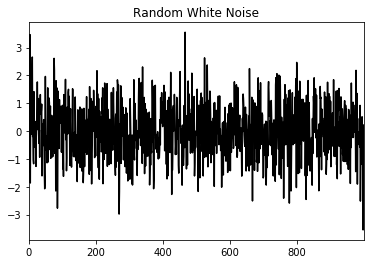

In [54]:
# white noise is completely random with 0 mean - there is no 
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k')
plt.show()

# Detrending a time series by either:
1. Subtract the line of best fit from the time series (linear or polynomial regression)
2. Subtract the trend component we saw from the stats library earlier
3. Subtract the Mean
4. Apply a filter like baxter-king or Hodrick-Prescott to remove the moving average trendlines or cyclical components

There are way to deseasonalize a time series, but I'm not particularly interested in these as I don't see them applying to stocks - perhaps commodities/metals could be an interesting place to investigate seasonality.

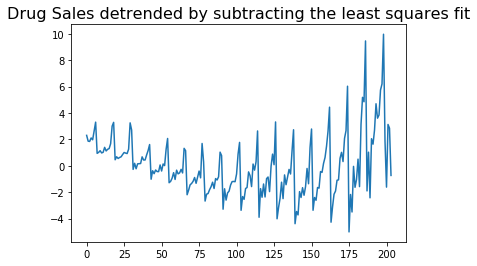

In [57]:
# # using scipy to detrend with line of best fit
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
# detrended = signal.detrend(df.value.values)
# plt.plot(detrended)
# plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)
# plt.show()

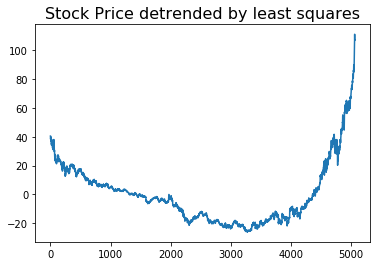

In [59]:
# # using scipy to detrend with line of best fit
# # im not sure what this offers us in terms of making stock predictions, but at least the library doesn't fail
# df = web.DataReader('MSFT', 'yahoo', start, end)
# detrended = signal.detrend(df['Adj Close'].values)
# plt.plot(detrended)
# plt.title('Stock Price detrended by least squares', fontsize=16)
# plt.show()

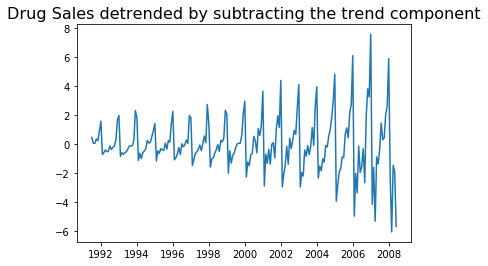

In [62]:
# # Using statmodels: Subtracting the Trend Component.
# # we already know this will fail with stock data - this library doesn't like messy stock data
# from statsmodels.tsa.seasonal import seasonal_decompose
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
# result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
# detrended = df.value.values - result_mul.trend
# plt.plot(detrended)
# plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)
# plt.show()

# Autocorrelation Function Plot
ACF plot can help show us if there is any seasonality, and the period(s) of it

Autocorrelation is the correlation of a time series with its lags. If a series is significantly autocorrelated, that means the previous values of the series may be helpful in predicting the current value. Partial Autocorrelation conveys the 'pure' correlation of a series and its lag, excluding the correlation of contributions from the intermediate lags. 

## How to compute the partial autocorrelation functions:
The partial autocorrelation of lag$[k]$ of a series is the coefficient of that lag in the autoregression equation of y. The autoregressive equation of Y is the linear regression of Y with its of lags as predictors. For example the partial autocorrelation of lag 3 is the coefficient $\alpha_3$ in the following:

$Y_t = \alpha_0+\alpha_1Y_{t-1}+\alpha_2Y_{t-2}+\alpha_3Y_{t-3}$

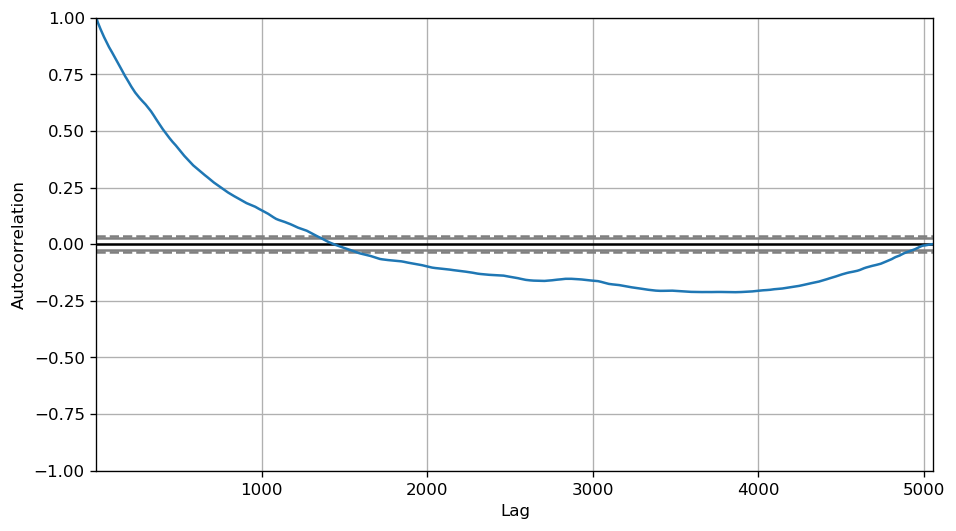

In [72]:
# Autocorrelation - for Adj. Close
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['Adj Close'].tolist())

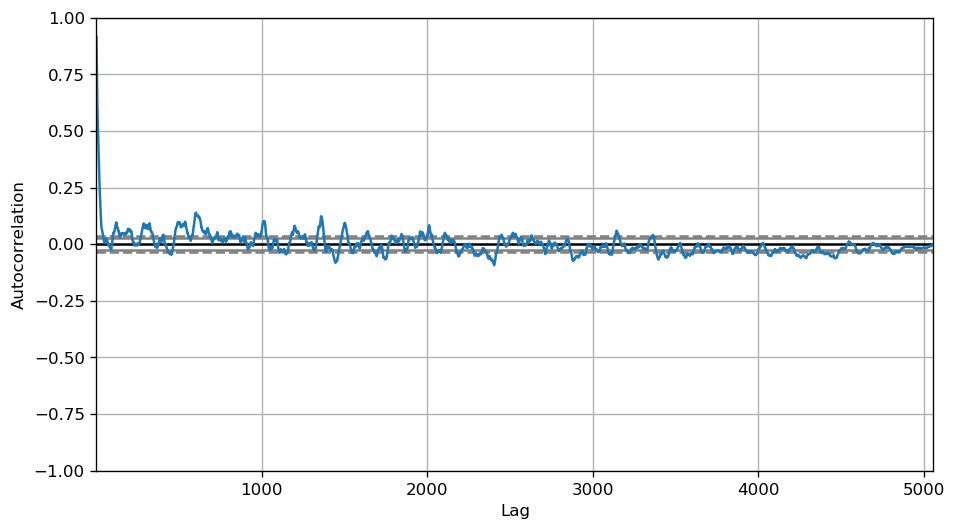

In [74]:
# Autocorrelation - for rsi
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['rsi'].tolist())
plt.show()

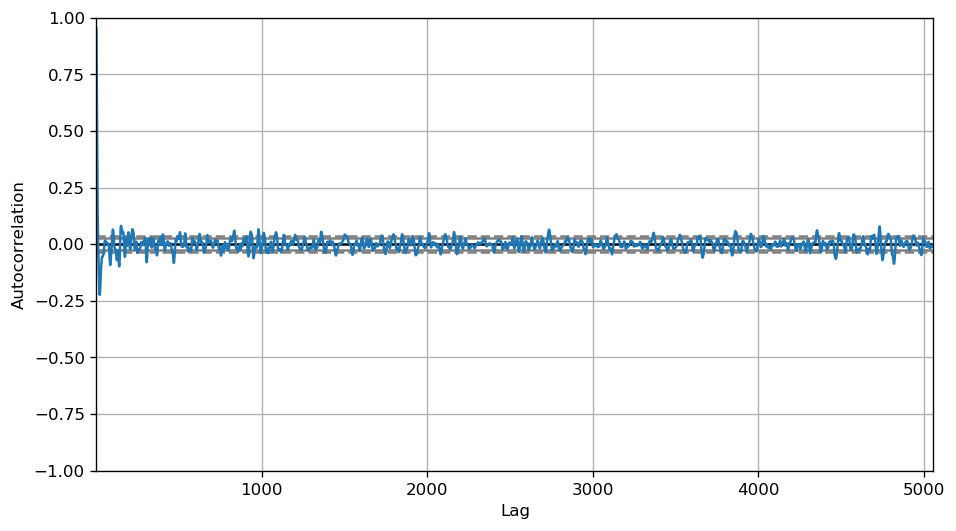

In [79]:
# Draw Plot - for macd
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['MACD_diff'].tolist())
plt.show()

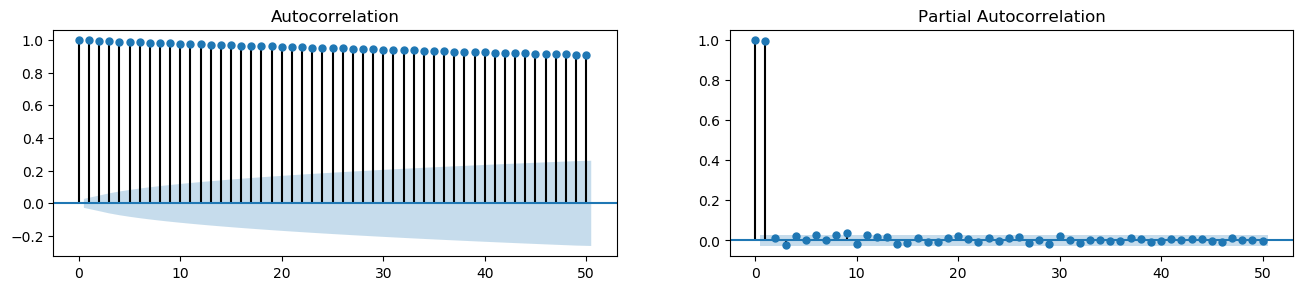

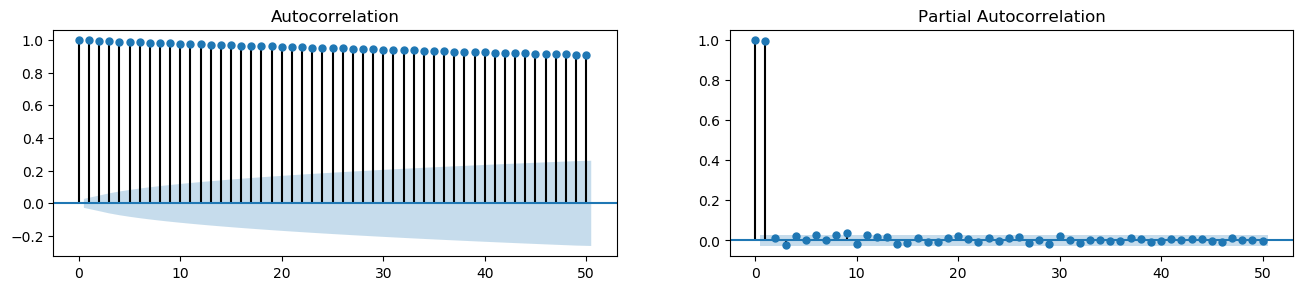

In [76]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Adj Close'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Adj Close'].tolist(), lags=50, ax=axes[1])

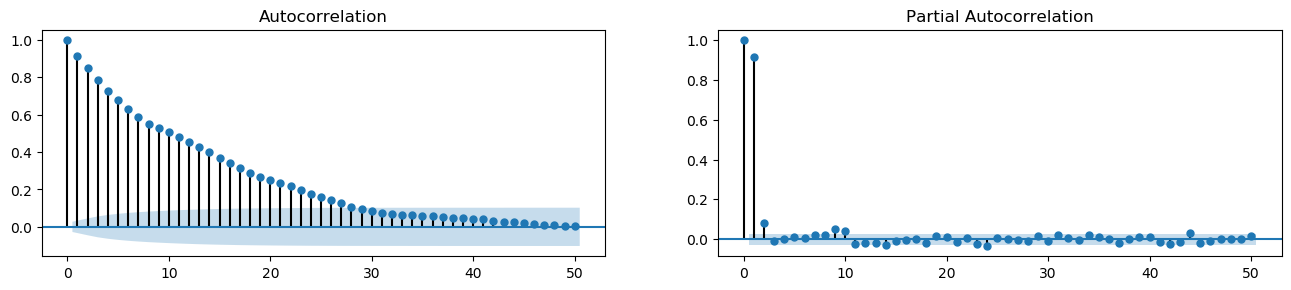

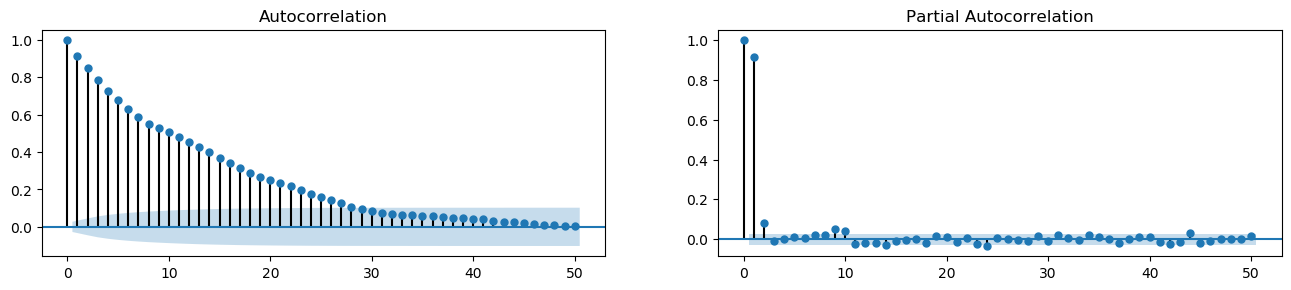

In [80]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['rsi'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['rsi'].tolist(), lags=50, ax=axes[1])

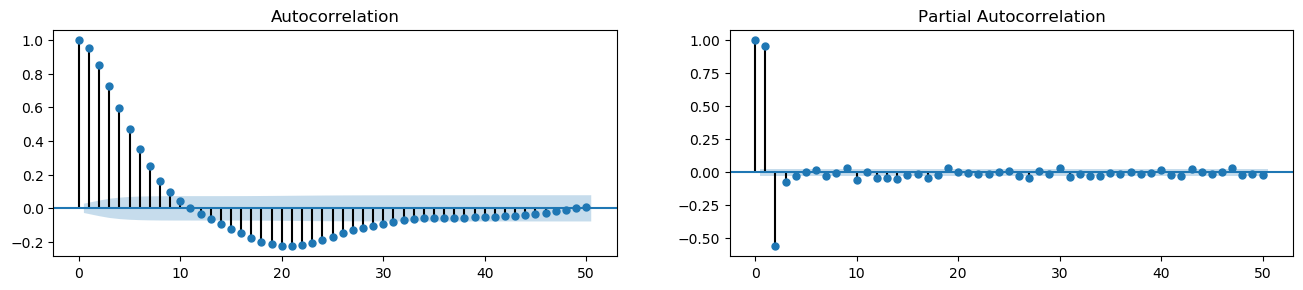

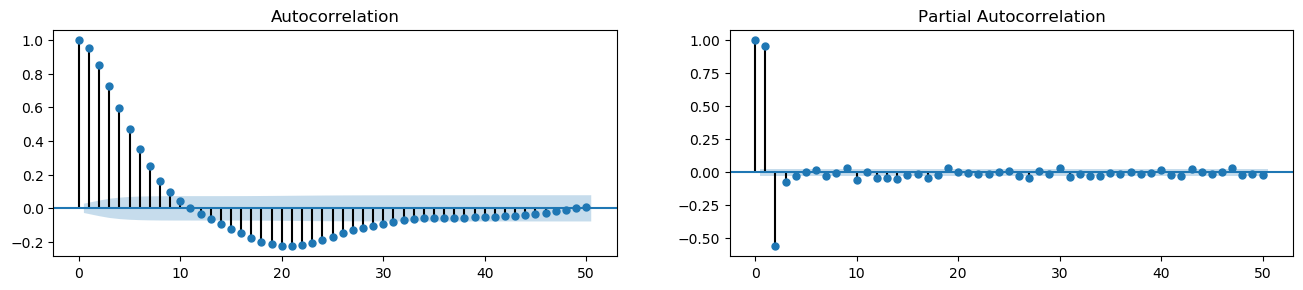

In [81]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['MACD_diff'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['MACD_diff'].tolist(), lags=50, ax=axes[1])

# Lag Plots
A Lag plot is a scatter plot of a time series against a lag of itself. Patterns in the plot are indications of autocorrelation. No patterns can indicate the series is white noise / random

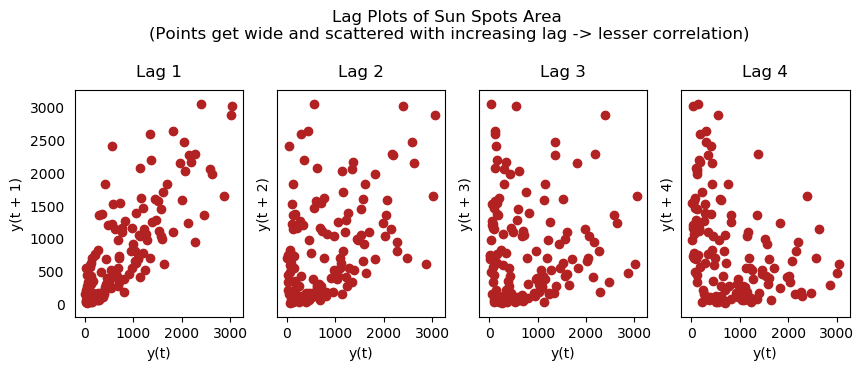

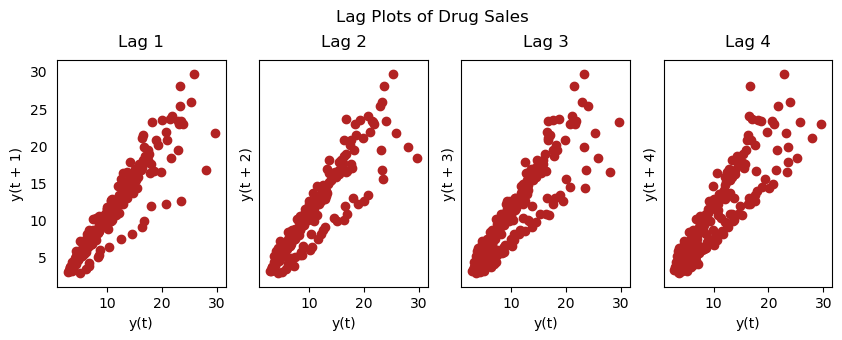

In [83]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Import
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

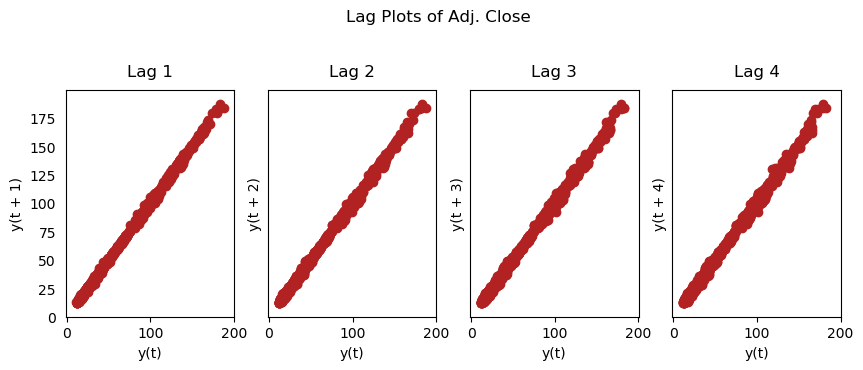

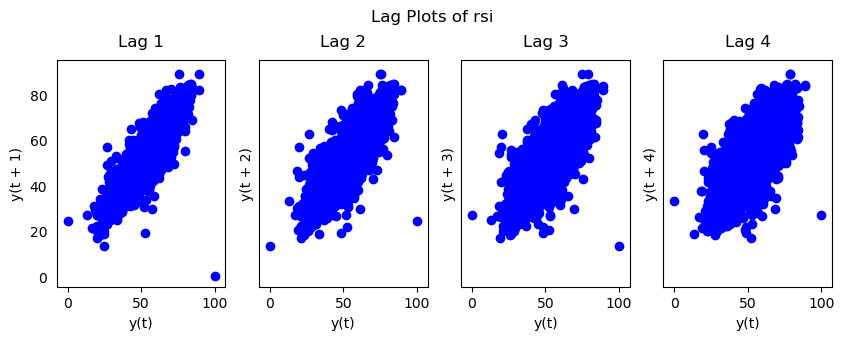

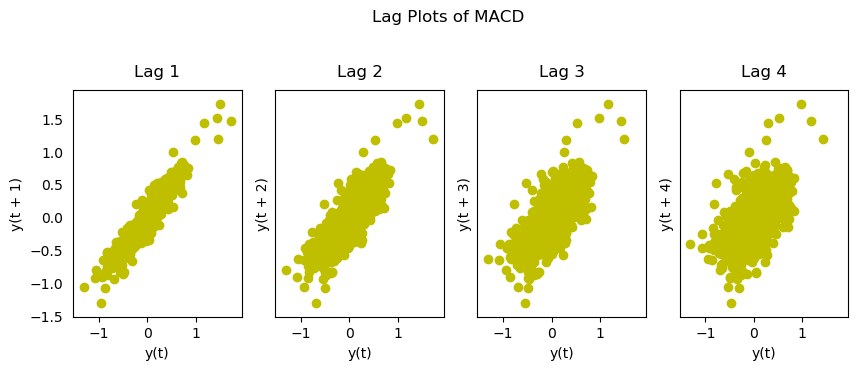

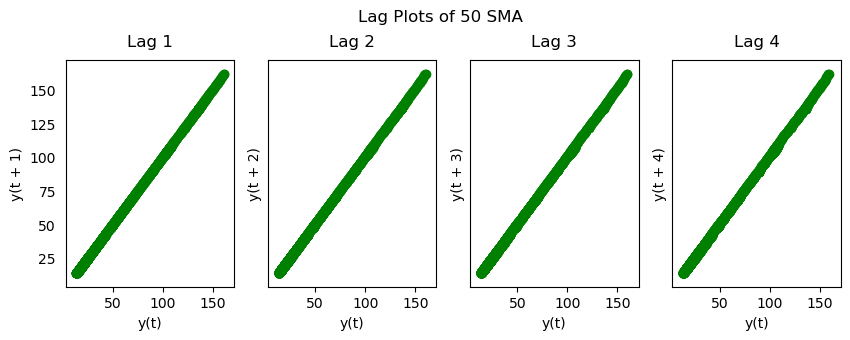

In [88]:
# lets try it for stonks
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['Adj Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Adj. Close \n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['rsi'], lag=i+1, ax=ax, c='b')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of rsi', y=1.05)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['MACD_diff'], lag=i+1, ax=ax, c='y')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of MACD', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['sma_50'], lag=i+1, ax=ax, c='g')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of 50 SMA', y=1.05)    
plt.show()

# Estimate the forecastability of a time series
Approximate Entropy can be used to quantify the regularity and unpredictability of fluctuations in a time series. The higher the approximate entropy, the harder it is to forecast.

Sample Entropy is similar and more consistent

In [90]:
# https://en.wikipedia.org/wiki/Approximate_entropy
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(ss.value, m=2, r=0.2*np.std(ss.value)))     # 0.651
print(ApEn(a10.value, m=2, r=0.2*np.std(a10.value)))   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.6514704970333534
0.5374775224973489
0.3192686682018149
0.7669020356057965


In [93]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(ss.value, m=2, r=0.2*np.std(ss.value)))      # 0.78
print(SampEn(a10.value, m=2, r=0.2*np.std(a10.value)))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.7853311366380039
0.41887013457621214


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


inf
2.3556949183079943


# Smoothing
* Reduce the effect of noise and get an approximation of the noise-filtered series
* Visualize the trend

### 3 Methods
1. Take a moving average
2. Do a LOESS smoothing (LOcalized RegrESSion)
3. Do a LOWESS smoothing (LOcally Weighted regrESSion)

in the statsmodels package, the frac argument specifies the percentage of data points nearby that should be considered to fit a regression model
